In [46]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from utils.T1Dataset import T1Dataset_regression_mr_path_test
from models.SENet import Model_path_mr
from lifelines.utils import concordance_index
from models.MLP import MLP
import torch
import torchtuples as tt
from utils.img_processing import convert_path,normalize_min_max
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.statistics import logrank_test

In [ ]:
df_train = normalize_min_max(df_train)

In [42]:
csv_dir = [['G:/glioma/final_data/glioma_survive/only_path/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/train_TCGA.csv',
           'G:/glioma/final_data/glioma_survive/mr_pathology/ex_test_huashan.csv','G:/glioma/final_data/glioma_survive/mr_pathology/ex_train_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology/test_huashan.csv','G:/glioma/final_data/MR_csv/glioma_survive/mr_pathology/train_huashan.csv',
            'G:/glioma/final_data/glioma_survivemr_pathology/ex_test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/ex_train_TCGA.csv']]
i = 0
df_train = pd.read_csv(csv_dir[i][1])
train_name = pd.DataFrame(df_train['patient'])
df_test = pd.read_csv(csv_dir[i][0])
test_name = pd.DataFrame(df_test['patient'])
df_ex_test = normalize_min_max(pd.read_csv(csv_dir[i][0]))
df_TCGA = pd.concat([df_train,df_test],axis=0)
df_TCGA = normalize_min_max(df_TCGA)
df_train_ = pd.merge(train_name,df_TCGA,how='inner')
df_test_ =  pd.merge(test_name,df_TCGA,how='inner')

(0.0485, 0.399]组的中位生存时间:65.71
(0.399, 1.0]组的中位生存时间:11.73
8.759104729927855e-28


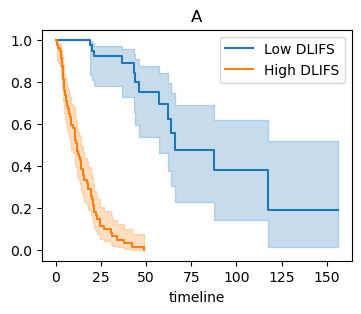

In [53]:
mean_risk_factor,max_risk_factor,min_risk_factor   = df_train_['score'].median(),df_train_['score'].max(),df_train_['score'].min()
df_train_['risk_'] = pd.cut(df_train_['score'],[min_risk_factor, mean_risk_factor, max_risk_factor])
df_test_['risk_'] = pd.cut(df_test_['score'],[min_risk_factor, mean_risk_factor, max_risk_factor])
df_ex_test['risk_'] = pd.cut(df_ex_test['score'],[min_risk_factor, mean_risk_factor, max_risk_factor])
plt.figure(figsize=(4,3))
kmf = KaplanMeierFitter()
itr = 0
for name, grouped_df in df_train_.groupby('risk_'):
    if itr == 0:
        target = 'Low DLIFS'
        group1 = grouped_df
    else:
        target = 'High DLIFS'
        group2 = grouped_df
    itr+= 1
    kmf.fit(grouped_df["survival_month"], grouped_df["status_dead"], label= target)
    if itr == 0:
        kmf1 = kmf
    else:
        kmf2 = kmf
    kmf.plot_survival_function()
    median = median_survival_times(kmf)
    print(f"{name}组的中位生存时间:{median}")
    plt.title('A')
results = logrank_test(group1['survival_month'].values, group2['survival_month'].values, 
                       group1['status_dead'].values, group2['status_dead'].values)
p_value = results.p_value
print(p_value)
    # Kaplan-Meier analysis according to the DLIFS for overall survival in the training set

(0.0485, 0.399]组的中位生存时间:inf
(0.399, 1.0]组的中位生存时间:9.79
1.7045341689101158e-21


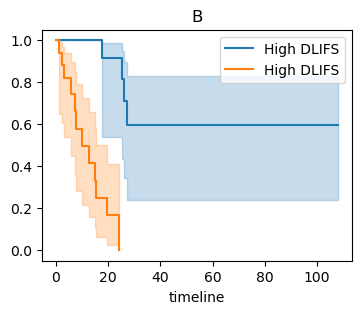

In [57]:
plt.figure(figsize=(4,3))
for name, grouped_df in df_test_.groupby('risk_'):
    if itr == 0:
        target = 'Low DLIFS'
        group1 = grouped_df
    else:
        target = 'High DLIFS'
        group2 = grouped_df
    itr+= 1
    kmf.fit(grouped_df["survival_month"], grouped_df["status_dead"], label= target)
    if itr == 0:
        kmf1 = kmf
    else:
        kmf2 = kmf
    kmf.plot_survival_function()
    median = median_survival_times(kmf)
    print(f"{name}组的中位生存时间:{median}")
    plt.title('B')
results = logrank_test(group1['survival_month'].values, group2['survival_month'].values, 
                       group1['status_dead'].values, group2['status_dead'].values)
p_value = results.p_value
print(p_value)
    # Kaplan-Meier analysis according to the DLIFS for overall survival in the testing set

(0.0485, 0.399]组的中位生存时间:inf
(0.399, 1.0]组的中位生存时间:15.34
4.207847567768683e-15


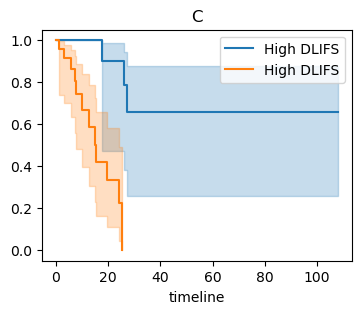

In [56]:
plt.figure(figsize=(4,3))
for name, grouped_df in df_ex_test.groupby('risk_'):
    if itr == 0:
        target = 'Low DLIFS'
        group1 = grouped_df
    else:
        target = 'High DLIFS'
        group2 = grouped_df
    itr+= 1
    kmf.fit(grouped_df["survival_month"], grouped_df["status_dead"], label= target)
    if itr == 0:
        kmf1 = kmf
    else:
        kmf2 = kmf
    kmf.plot_survival_function()
    median = median_survival_times(kmf)
    print(f"{name}组的中位生存时间:{median}")
    plt.title('C')
results = logrank_test(group1['survival_month'].values, group2['survival_month'].values, 
                       group1['status_dead'].values, group2['status_dead'].values)
p_value = results.p_value
print(p_value)
    # Kaplan-Meier analysis according to the DLIFS for overall survival in the external testing set